# Stratigraphic reconstruction from terahertz and ultrasonic signals by deconvolution: a review
## **Supplementary material**

Additional supplementary material is here provided to support and enhance the main findings of the study *Zito, R., Shi, H. et al. - "Stratigraphic reconstruction from terahertz and ultrasonic signals by deconvolution: a review"*. These include the codes of the algorithms proposed in our paper and the visualizations of the results obtained. The supplementary content is intended to provide clarity, reproducibility, and further context for the methods.

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import Deconvolution
from scipy.linalg import toeplitz
from scipy.io import loadmat

## **Benchmark**
To evaluate the performance of the proposed algortithms, here we present a benchmark based on a simple test case.

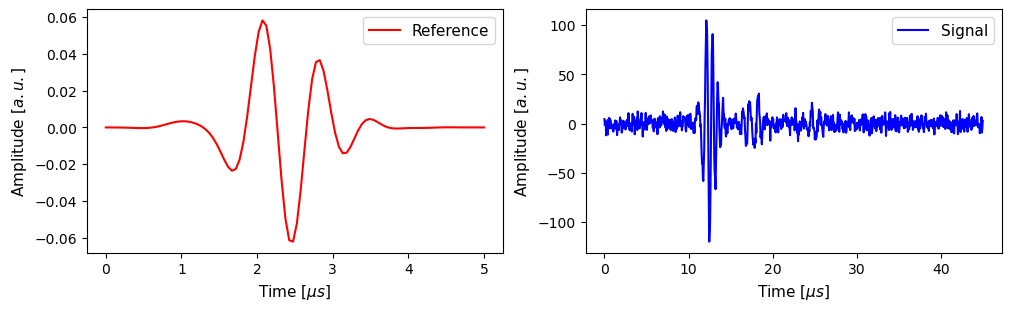

In [5]:
# Import reference
Reference = loadmat('./Data/UT.mat')['ref'].squeeze()
Signal = loadmat('./Data/AScanUT.mat')['prova'].squeeze()

# Create time vectors
dt = 5e-8
tR = np.linspace(0,len(Reference)*dt,len(Reference))*1e6
tS = np.linspace(0,len(Signal)*dt,len(Signal))*1e6

# Plot reference, impulse response and noisy signal
plt.figure(figsize=(10,3),constrained_layout=True)
plt.subplot(121)
plt.plot(tR,Reference,label='Reference',color='red')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.subplot(122)
plt.plot(tS,Signal,label='Signal',color='blue')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.show()

## **Orthogonal Matching Pursuit (OMP)**

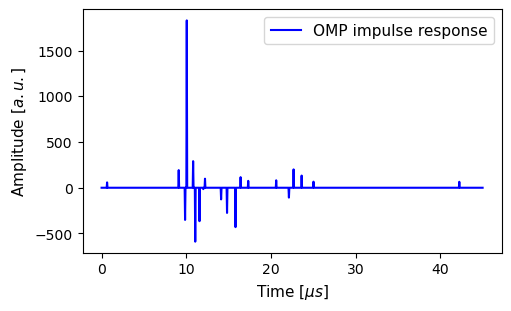

In [6]:
# Initialize parameters
N = 20

aOMP,tOMP,hOMP = Deconvolution.OMP(Signal,Reference,N)

# Plot OMP results
plt.figure(figsize=(5,3),constrained_layout=True)
plt.plot(tS,hOMP,label='OMP impulse response',color='blue')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.show()

## **ℓ1-norm deconvolution: Sparse Deconvolution (SD)**

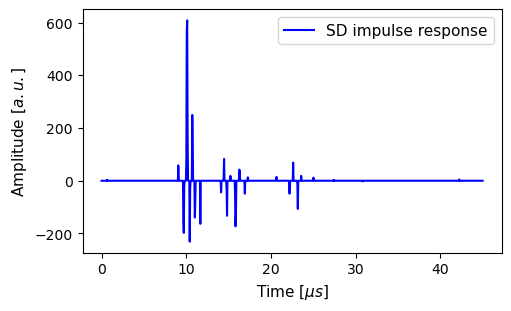

In [7]:
# Initialize parameters
Ns = len(Signal)
Nw = len(Reference)
X = toeplitz(np.r_[Reference, np.zeros(Ns-Nw)],np.r_[Reference[0], np.zeros(Ns-1)])
mu = 1/np.linalg.norm(X@X.T,2)
lam = 2
N_iter = 500

hSD = Deconvolution.SD(Signal,Reference,mu,lam,N_iter)

# Plot SD results
plt.figure(figsize=(5,3),constrained_layout=True)
plt.plot(tS,hSD,label='SD impulse response',color='blue')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.show()

## **MUltiple SIgnal Classification (MUSIC)**

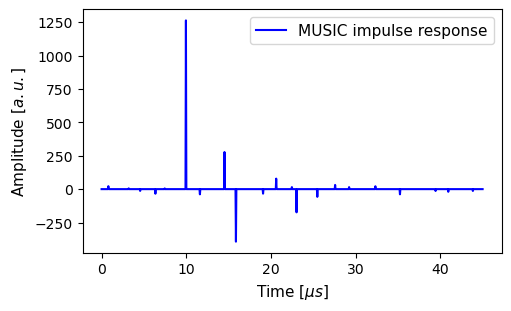

In [8]:
# Initialize parameters
NSub = 10
BW = 0.1

aMUSIC,tMUSIC,hMUSIC = Deconvolution.MUSIC(Signal,Reference,NSub,BW)

# Plot MUSIC results
plt.figure(figsize=(5,3),constrained_layout=True)
plt.plot(tS,hMUSIC,label='MUSIC impulse response',color='blue')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.show()

## **Autoregressive spectral extrapolation (AR)**

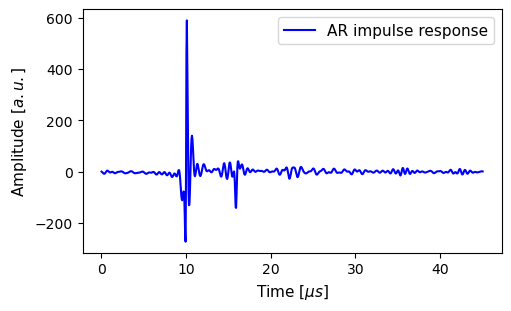

In [9]:
# Initialize parameters
BW = 0.3
p = 10

hAR = Deconvolution.AR(Signal,Reference,p,BW)

# Plot AR results
plt.figure(figsize=(5,3),constrained_layout=True)
plt.plot(tS[1:],hAR,label='AR impulse response',color='blue')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.show()

For more information refer to the article:

*Zito, R., Shi, H. et al. - 'Stratigraphic reconstruction from terahertz and ultrasonic signals by deconvolution: a review'*